### Auto-Regressive Integrated Moving Average (ARIMA)

This notebook explains the checking of seasonality and stationarity of the data and the first time series analysis with ARIMA.

The content of the notebook is as follows:

    Time Series Decomposition
    Extracting the yearly seasonality

    Checking the stationarity
    Statistical Test for checking stationarity
    Rolling Statistics
    Augmented Dickey-Fuller test

    How to make the data stationary

    De-trend the Time Series
    Seasonal differencing

    ARIMA Model

    Summary


### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from ftplib import FTP
import os
import warnings
from datetime import datetime

# # Data Viz. 
# import statsmodels.formula.api as smf
# from statsmodels.tsa.seasonal import seasonal_decompose
# from scipy.ndimage import gaussian_filter
# from calendar import monthrange
# from calendar import month_name

# Plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

plt.rcParams.update({'figure.facecolor':'white'})

In [ ]:
#import statsmodels.formula.api as smf

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the data
df = pd.read_csv('data/N_seaice_extent_daily_v3.0.csv')
# df.head()

In [6]:
# Changing column names
df = df.rename(columns={'Year': 'Year', ' Month': 'Month', ' Day': 'Day', '     Extent': 'Extent', '    Missing': 'Missing', ' Source Data': 'Source Data' })

In [8]:
# Dropping the column "Source"
df.drop('Source Data', axis = 1, inplace = True)


In [21]:
# Creating a new column with date
df['date']=pd.to_datetime(df[['Year','Month','Day']])

### Adding Missing values

In [22]:
df2 = df[['date', 'Extent']]
# in the first timeperiod we only have values for every second day
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range(df2['date'].min(), df2['date'].max()), columns=['date'])
# from the all_dates DataFrame, left join onto the DataFrame with missing dates
df_n = all_dates.merge(right=df2, how='left', on='date')
# filling the NaN values with the values of the day before
df_n.fillna(method='ffill', inplace=True)
df_n = df_n.reset_index(drop=True)
df_n.tail()

,date,Extent
15831,2022-02-28,14.671
15832,2022-03-01,14.693
15833,2022-03-02,14.765
15834,2022-03-03,14.703
15835,2022-03-04,14.748


In [23]:
df2.to_csv('data/NH_modelling.csv', encoding='utf-8', index=False)

Converting date, day, month and year to timestamp format 

In [38]:
df_n['date'] = pd.to_datetime(df_n['date'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_n = df_n.assign(
    timestamp = lambda x: pd.to_datetime(x['date']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['date'].dt.dayofyear
)

In [26]:
df_n.dtypes

date         datetime64[ns]
Extent              float64
timestamp    datetime64[ns]
year                  int64
month                 int64
day                   int64
dtype: object

### Time Series Analysis 

Plot yearly seasonality

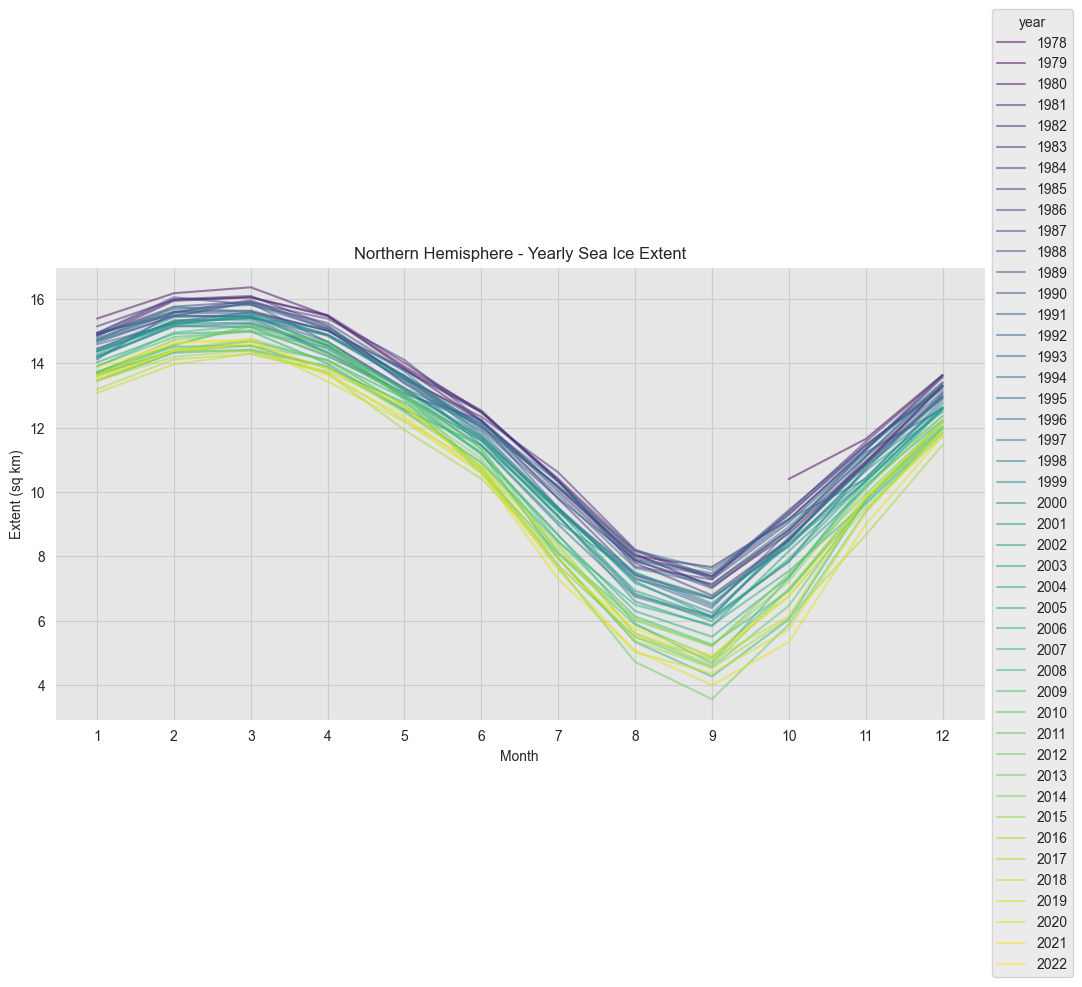

In [84]:
# Plot yearly seasonality
fig, ax = plt.subplots() 

pd.pivot_table(data=df_n[['year', 'month', 'Extent']], index='month', columns='year') \
    ['Extent'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Northern Hemisphere - Yearly Sea Ice Extent', xlabel='Month', ylabel='Extent (sq km)')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12]);

fig.savefig('images/northern_hemisphere.png', dpi=400)

**This plot shows that the sea ice is maximum on March and after March it starts to melt and the minimum sea ice is on september.**
**There is a clear evidence there is a drastic change from 1978 till 2022. The lowest sea ice was on 2012.**
**Every year the total amount of sea ice forming after it melts in summer, is also decreasing.**

**It shows a clear trend and seasonality of every year. The seasonality has a period of one year.**

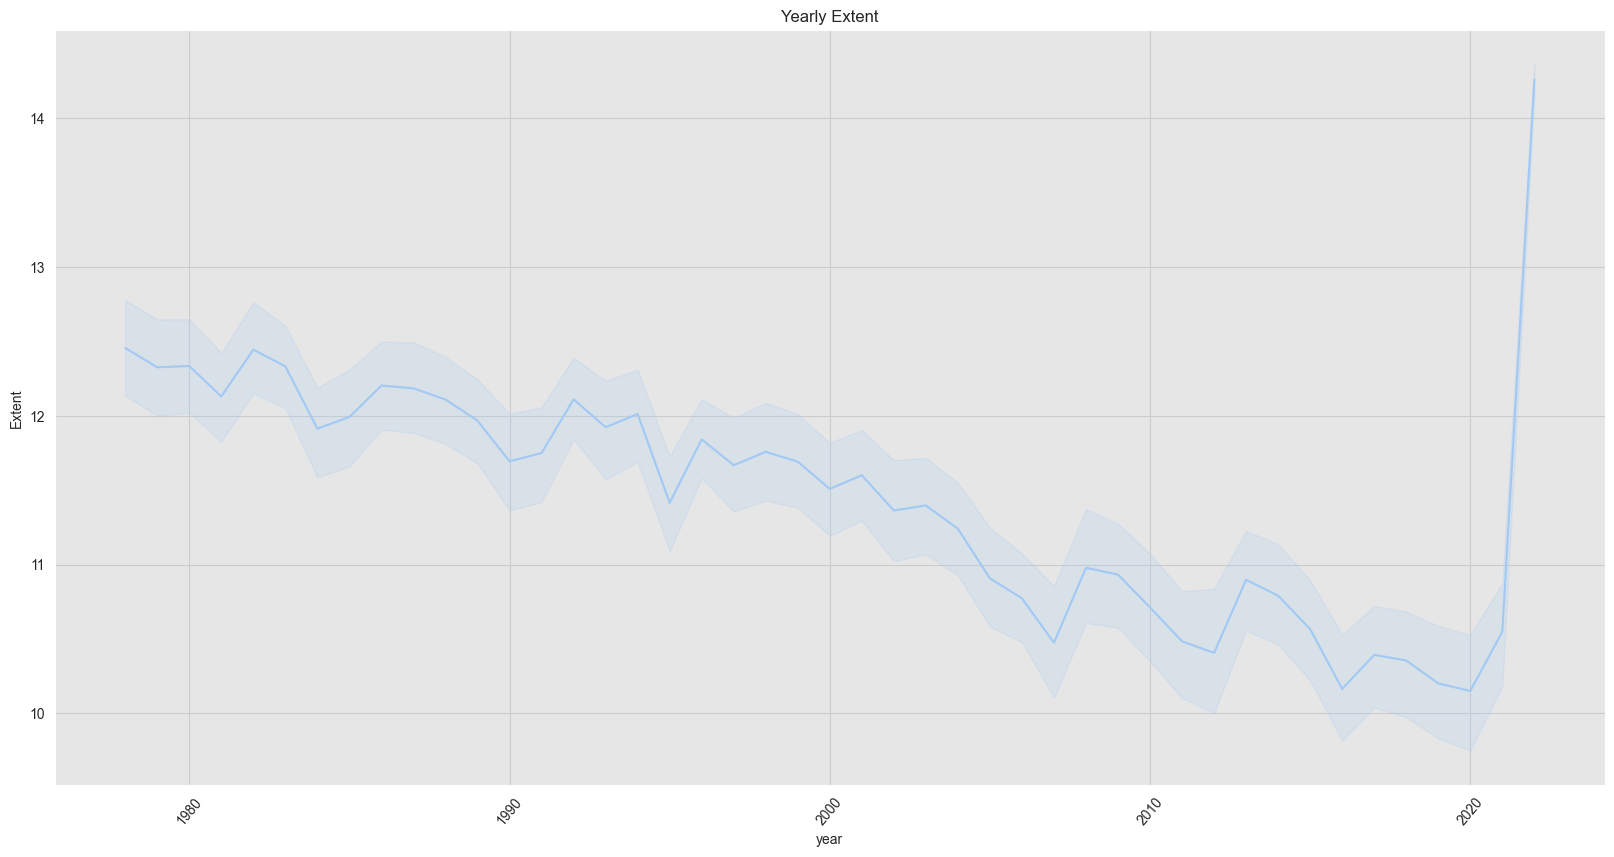

In [40]:
palette = sns.color_palette("bright")
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x='year', y='Extent', data=df_n, ax=ax)
ax.set(title='Yearly Extent', ylabel='Extent')

plt.xticks(rotation=50);

**This yearly plot clearly shows the trend of decrease in sea ice from 1978 till 2021.**

### Time Series Decomposition

Time series decomposition is a mathematical procedure which transforms a time series into multiple different time series. The original time series is split into 3 component series: trend, seasonal and residual

Seasonality in time-series data refers to a pattern that occurs at a regular interval.


#### Extracting the yearly seasonality

In [41]:
df_NH= df_n[['date','Extent']]
df_NH.to_csv('data/Northern_H.csv', encoding='utf-8', index=False)

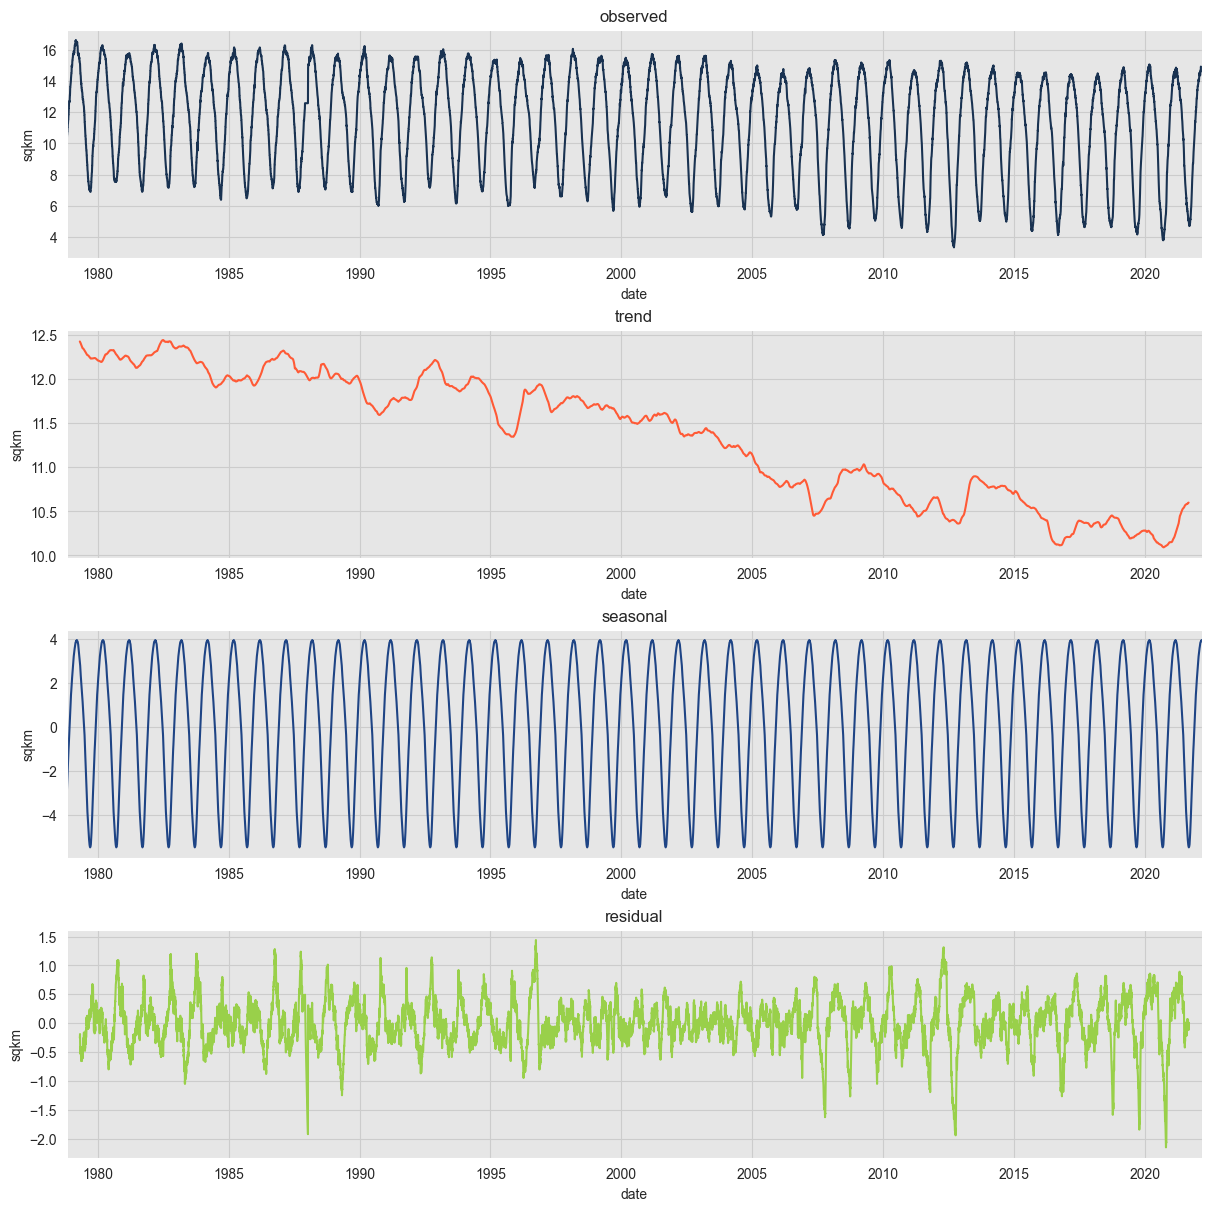

In [42]:
# We use the parameter `period` = 365 to extract the yearly seasonality.
from statsmodels.tsa.seasonal import seasonal_decompose
data=pd.read_csv('data/Northern_H.csv',header=0,squeeze=True,index_col=[0],parse_dates=[0])

seas_decomp_yearly = seasonal_decompose(
    data,
    model='additive',
    period=365
)
# Plot data
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])


ax[0].set(title='observed', ylabel=r'sqkm')
seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel=r'sqkm')
seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel=r'sqkm')
seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel=r'sqkm');

### Checking the stationarity

The observations in a stationary time series are not dependent on time. Time series are stationary if they do not have trend or seasonal effects.
Non-stationarity is often observed through changing mean or variance in the time series.

Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.

Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects.

If there is a clear trend and seasonality in the time series, then model these components, remove them from observations, then train models on the residuals.

If the time series is split into two (or more) partitions and compare the mean and variance of each group. If they differ and the difference is statistically significant, the time series is non-stationary.

In [43]:
# #from pandas import read_csv
# #series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
# X = df_n.values
# split = round(len(X) / 2)
# X1, X2 = X[0:split], X[split:]
# mean1, mean2 = X1.mean(), X2.mean()
# var1, var2 = X1.var(), X2.var()
# print('mean1=%f, mean2=%f' % (mean1, mean2))
# print('variance1=%f, variance2=%f' % (var1, var2))

### Statistical Test for checking stationarity

Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

#### Rolling Statistics:


#### Augmented Dickey-Fuller test:

It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

This result is interpreted using the p-value from the test. 

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [44]:
from statsmodels.graphics.tsaplots import plot_acf

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -19.143030
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.764849
p-value: 0.010000
----------------------------------------


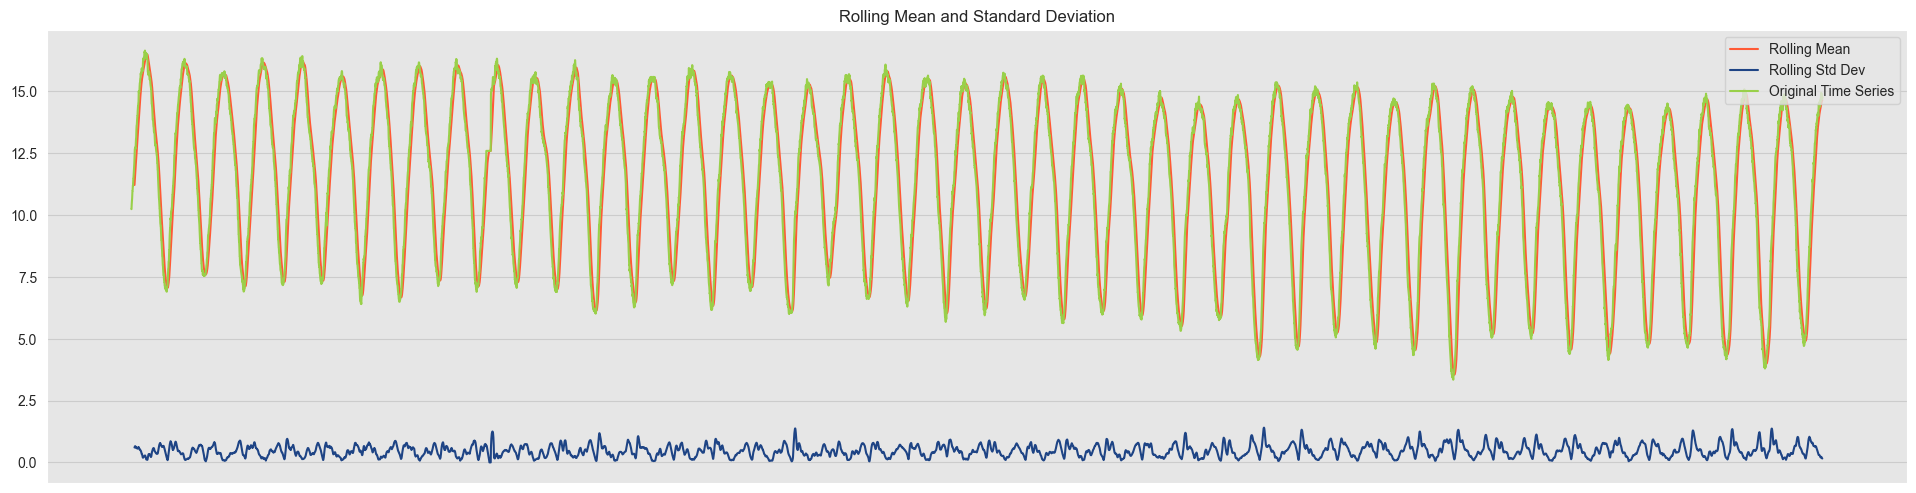

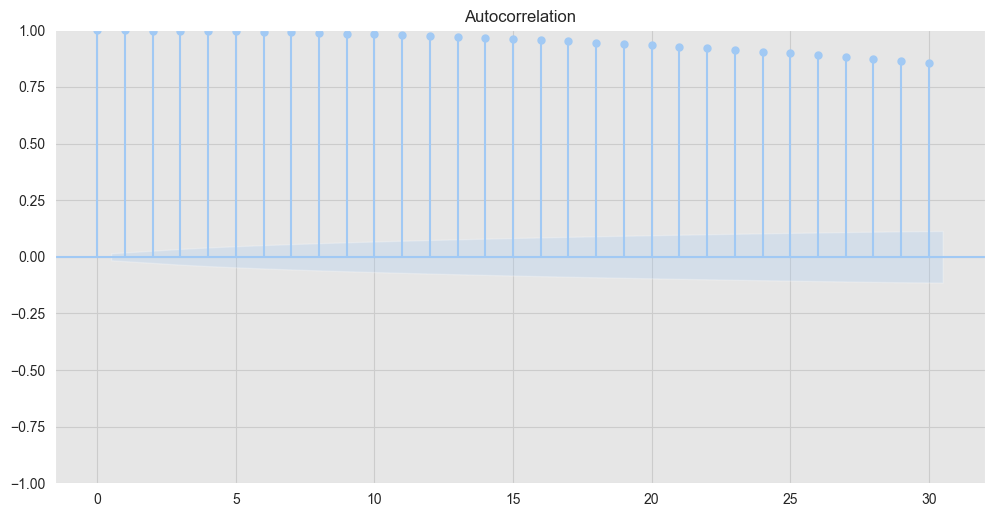

In [45]:
# Test for stationarity 

def stationarity_test(Northern_Hemi_Extent):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = Northern_Hemi_Extent.rolling(30).mean()
    rolling_std_dev = Northern_Hemi_Extent.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(Northern_Hemi_Extent, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(Northern_Hemi_Extent,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(Northern_Hemi_Extent, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_NH['Extent'])

# Partial Autocorrelation Plot
pacf = plot_acf(df_NH['Extent'], lags=30)

Though the variation in standard deviation is small, mean is clearly decreasing with time and this is not a stationary series. 

Also Here we have ADF statistic value of -16.441651. 

AutoCorrelation:

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function. The correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

**From the auto correlation plot, we can see that there is a positive correlation of slowly diminishing lags of a trend.**

## How to make the data stationary?

There are many ways to do change the non stationary time series to stationary.


1. Differencing (2 ways: Normal and Seasonal differencing)

### De-trend the Time Series

### Seasonal differencing

In [46]:
# De-trending the time series
df_NH['Extent_Detrend'] = (df_NH['Extent'] - df_NH['Extent'].shift(365))

<AxesSubplot:>

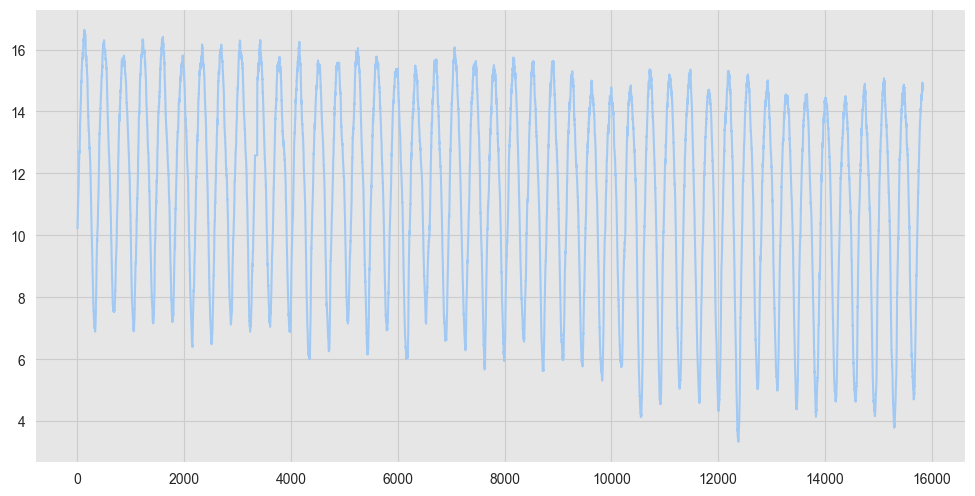

In [47]:
df_NH['Extent'].plot()

<AxesSubplot:>

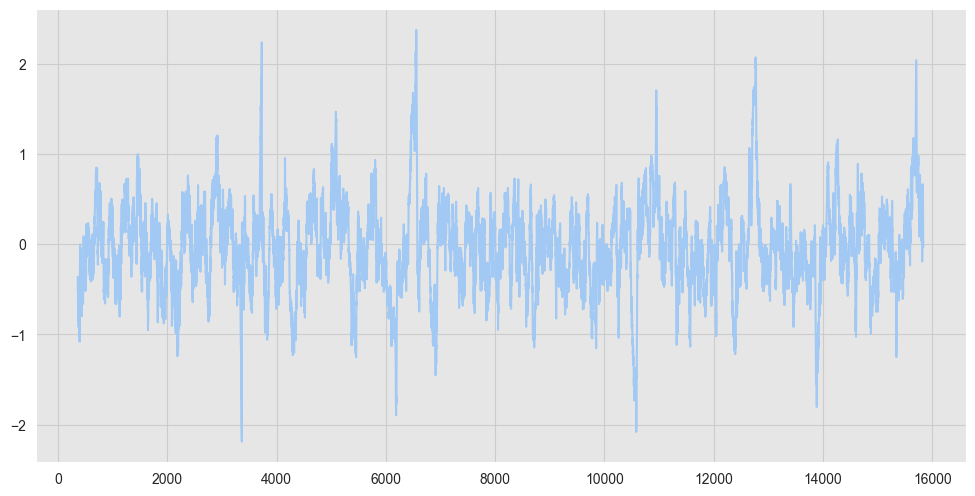

In [48]:
df_NH['Extent_Detrend'].dropna().plot()

In [49]:
df_NH.isnull().sum()

date                0
Extent              0
Extent_Detrend    365
dtype: int64

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -10.043556
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.087308
p-value: 0.100000
----------------------------------------


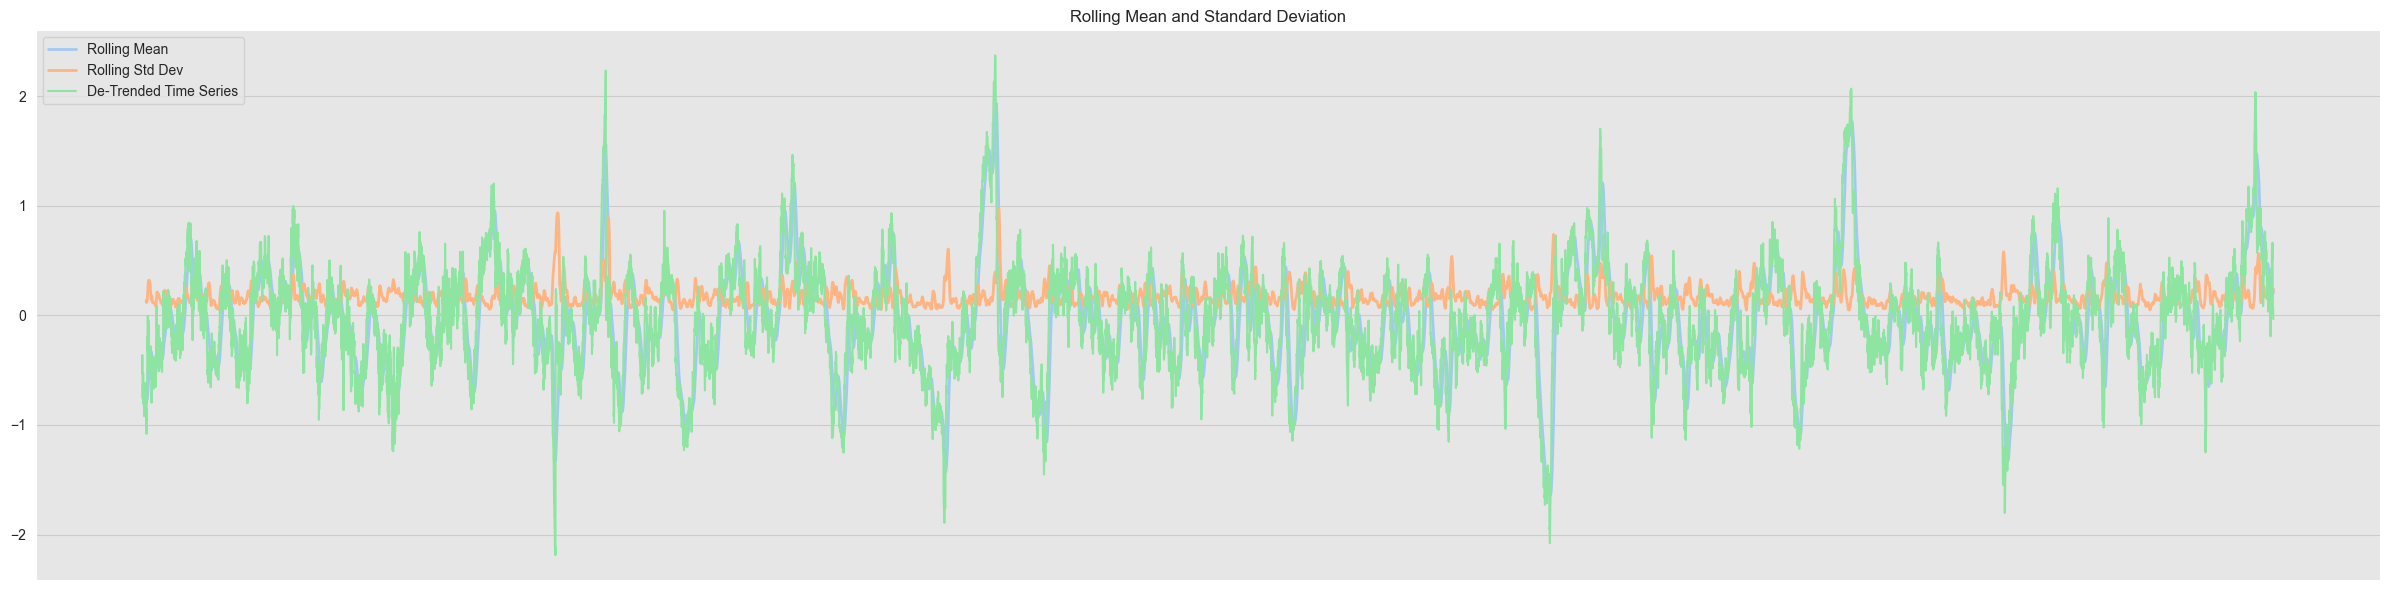

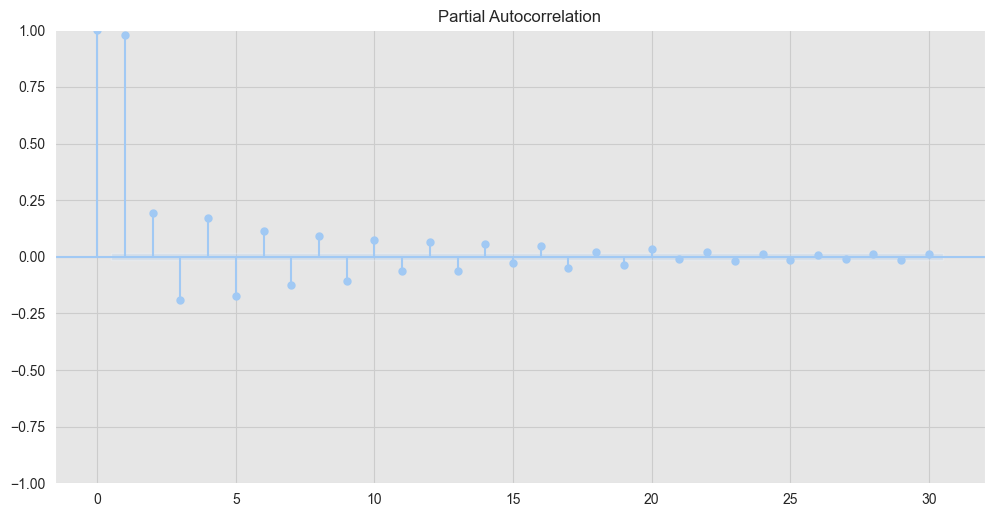

In [50]:
# Test for stationarity after de-trending 
def stationarity_test(stock_close_price):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(stock_close_price,label='De-Trended Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_NH['Extent_Detrend'].dropna())

# Partial Autocorrelation Plot
pacf = plot_pacf(df_NH['Extent_Detrend'].dropna(), lags=30)

Partial Autocorrelation Function:

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

### Correlation

In [51]:
df_NH.corr()

,Extent,Extent_Detrend
Extent,1.0000,0.0848
Extent_Detrend,0.0848,1.0000


### Smoothing

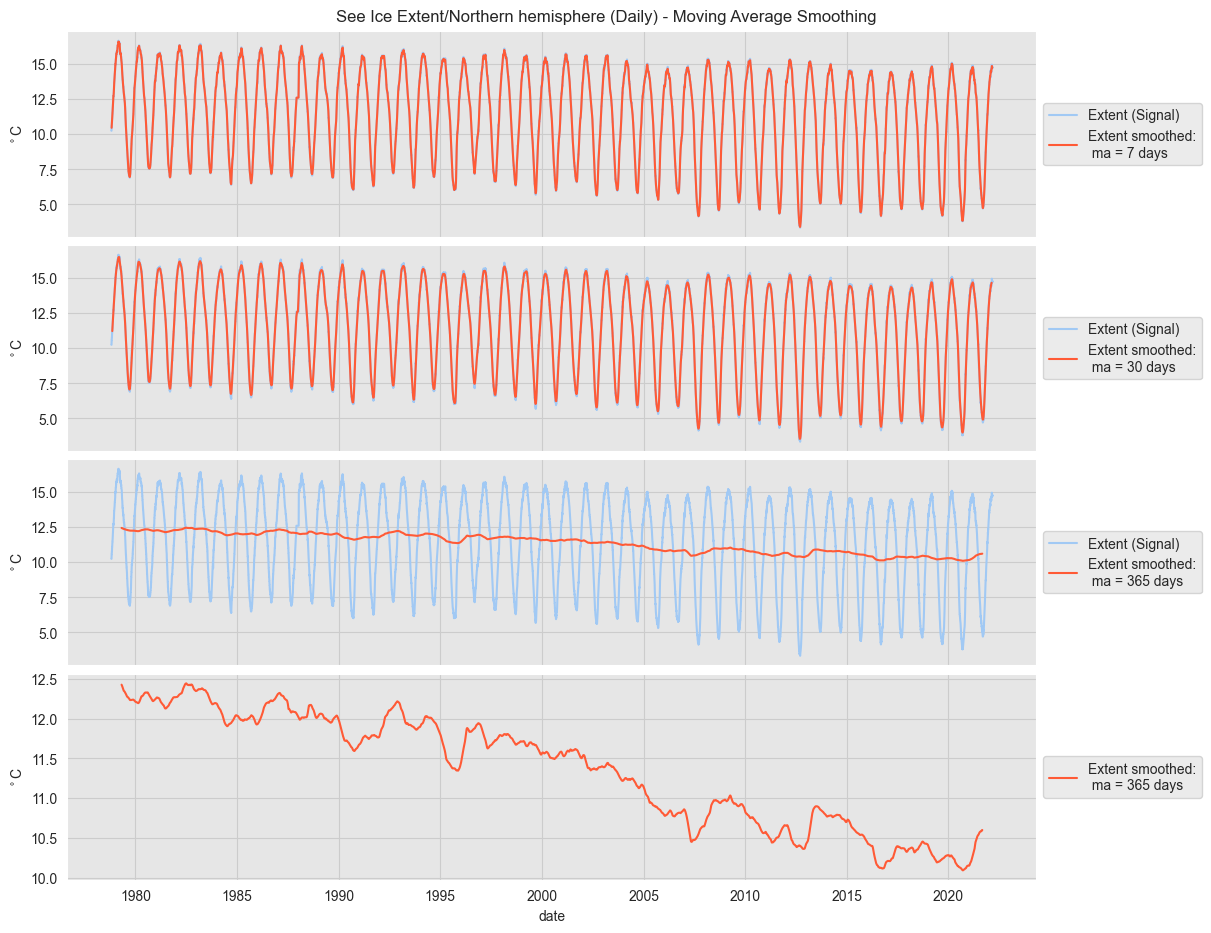

In [52]:
# Plot moving average of different length (week, month, year)
ma = [7, 30, 365]

smooth_df_NH = df_NH \
    .reset_index() \
    #.assign(date = lambda x: x['date'].transform(pd.to_datetime)) # creating a new column called date and transforming to datetime object

# Smooth and plot
fig, ax = plt.subplots(4, 1, figsize=(12, 9), constrained_layout=True, sharex=True)

for i, m in enumerate(ma):

    smooth_df_NH [f'extent_smooth_ma_{m}'] = smooth_df_NH['Extent'].rolling(window=m,center=True).mean()

    sns.lineplot(x='date', y='Extent', label='Extent (Signal)', data=smooth_df_NH,  ax=ax[i])
    sns.lineplot(x='date', y=f'extent_smooth_ma_{m}', label=f'Extent smoothed:\n ma = {m} days', data=smooth_df_NH, color=NF_ORANGE, ax=ax[i])


    ax[i].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].set(title='', ylabel=r'$^\circ$C');
    
sns.lineplot(x='date', y=f'extent_smooth_ma_{m}', label=f'Extent smoothed:\n ma = {m} days', data=smooth_df_NH, color=sns_c[1], ax=ax[i+1])
ax[i+1].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
ax[i+1].set(title='', ylabel=r'$^\circ$C');
    
    
plt.suptitle('See Ice Extent/Northern hemisphere (Daily) - Moving Average Smoothing', y=1.02);

### ARIMA model


### Splitting te data

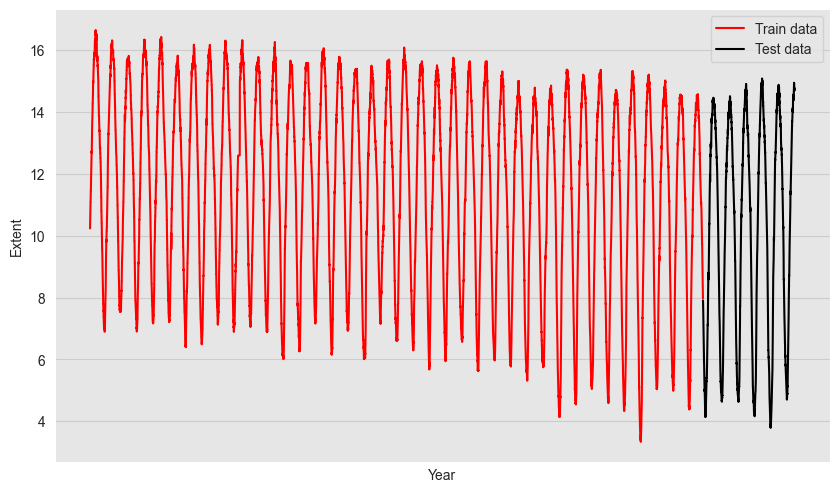

In [75]:
# Split data into train and test set
df_n_arima = df_n['Extent']
train_test_split_ratio = int(len(df_n_arima)*0.87)
train_data, test_data = df_n_arima[:train_test_split_ratio], df_n_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Extent')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

### Auto-Regressive Integrated Moving Average (ARIMA)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-28894.016, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=107552.557, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-28519.540, Time=1.90 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-28897.478, Time=1.72 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53127.446, Time=1.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-28519.855, Time=7.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=71196.817, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=3.30 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 18.801 seconds
                               SARIMAX Results                                
Dep. Variable:       

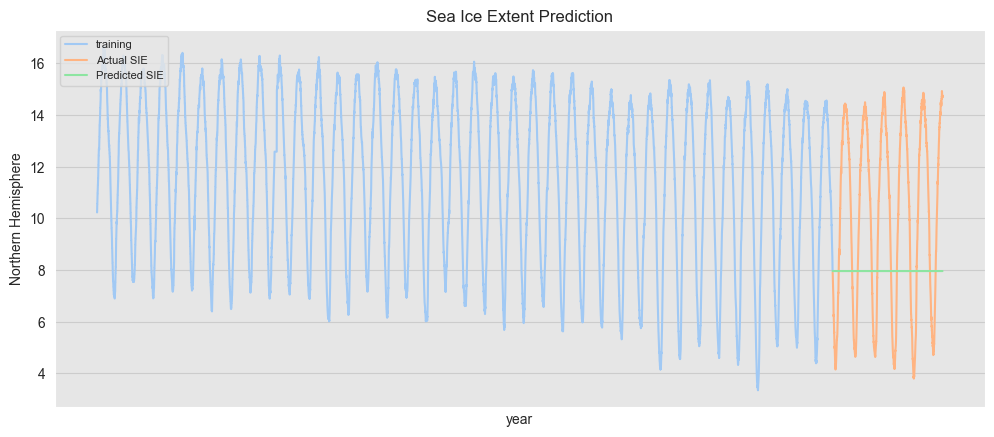

Auto-Arima RMSE :- 4.2


In [78]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=2, max_q=1,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual SIE')
plt.plot(fcv_series,label='Predicted SIE')
plt.title('Sea Ice Extent Prediction')
plt.xlabel('year')
plt.ylabel('Northern Hemisphere')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

### Splitting the dataset to test-train

In [55]:
df_n.head()

,date,Extent,timestamp,year,month,day
0,1978-10-26,10.231,1978-10-26,1978,10,26
1,1978-10-27,10.231,1978-10-27,1978,10,27
2,1978-10-28,10.420,1978-10-28,1978,10,28
3,1978-10-29,10.420,1978-10-29,1978,10,29
4,1978-10-30,10.557,1978-10-30,1978,10,30


In [56]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

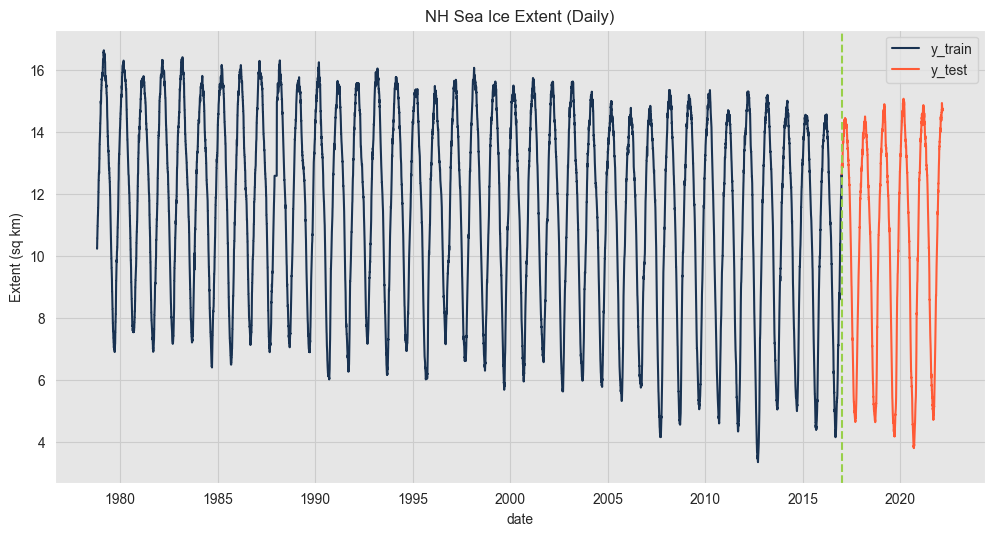

In [57]:
train_test_cut_date = '2017-01-01'
df_train = df_NH.query(f'date < "{train_test_cut_date}"')
df_test = df_NH.query(f'date >= "{train_test_cut_date}"')

fig, ax = plt.subplots()
sns.lineplot(x='date', y='Extent', data=df_train, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x='date', y='Extent', data=df_test, color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=train_test_cut_date, linestyle='--', color=sns_c[3], label='train-test-split')
ax.set(title='NH Sea Ice Extent (Daily)', ylabel='Extent (sq km)');

In [58]:
y_train = df_train['Extent'].to_numpy()
t_train = df_train['date'].to_numpy()
y_test =df_test['Extent'].to_numpy()
t_test = df_test['date'].to_numpy()

### Exponential Smoothing

In [59]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing


es_model = STLForecast(
    endog=y_train,
    period=365, 
    model=ExponentialSmoothing,
    model_kwargs={'trend': True}, 
    trend_deg=1
)

es_result = es_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.00722D-01    |proj g|=  4.43652D-01

At iterate    5    f= -1.47480D+00    |proj g|=  1.49926D-02

At iterate   10    f= -1.48992D+00    |proj g|=  2.59310D-02

At iterate   15    f= -1.49387D+00    |proj g|=  6.37086D-03

At iterate   20    f= -1.49430D+00    |proj g|=  3.00948D-02

At iterate   25    f= -1.49501D+00    |proj g|=  6.04995D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     29      1     0     0   

### Forecasting with Exponential Smoothing

In [60]:
y_pred_es = es_result.forecast(y_test.size)

In [61]:
# # Evaluate the model by calculating RMSE
# rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
# print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

# rmse_es = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_es))

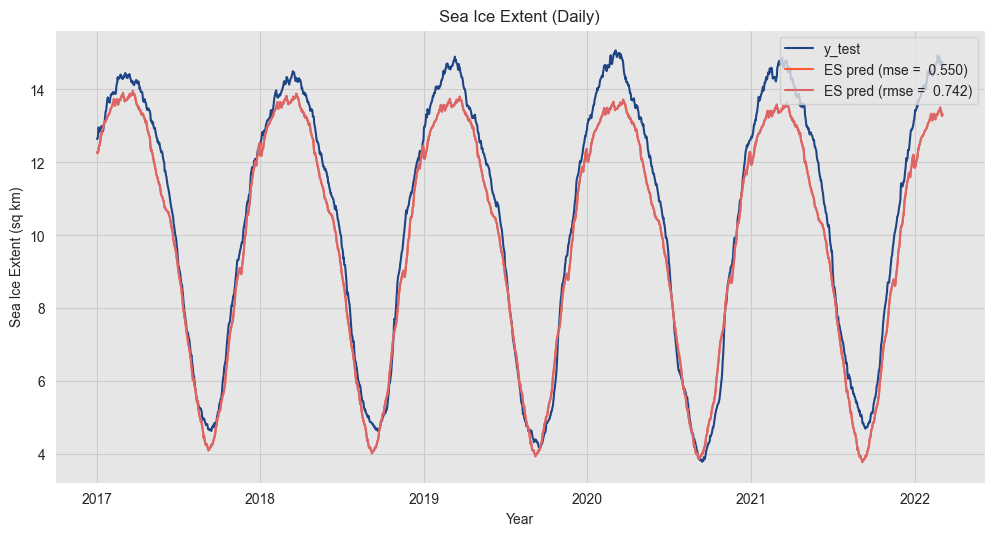

In [62]:
from sklearn.metrics import mean_squared_error

mse_es = mean_squared_error(y_true=y_test, y_pred=y_pred_es)
rmse_es = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_es))

fig, ax = plt.subplots()
sns.lineplot(x=t_test, y=y_test, color=sns_c[2], label='y_test', ax=ax)
sns.lineplot(x=t_test, y=y_pred_es, color=sns_c[4], label=f'ES pred (mse = {mse_es: 0.3f})', ax=ax)
sns.lineplot(x=t_test, y=y_pred_es, color=sns_c[5], label=f'ES pred (rmse = {rmse_es: 0.3f})', ax=ax)
ax.set(title='Sea Ice Extent (Daily)', xlabel='Year', ylabel='Sea Ice Extent (sq km)');

### ARIMA Model

In [67]:

arima_model = STLForecast(
    endog=y_train,
    period=365, 
    model=ARIMA,
    model_kwargs={'order': (2, 1, 1)},
    trend_deg=1
)

arima_result = arima_model.fit()

### Forecasting

In [68]:
y_pred_arima = arima_result.forecast(y_test.size)


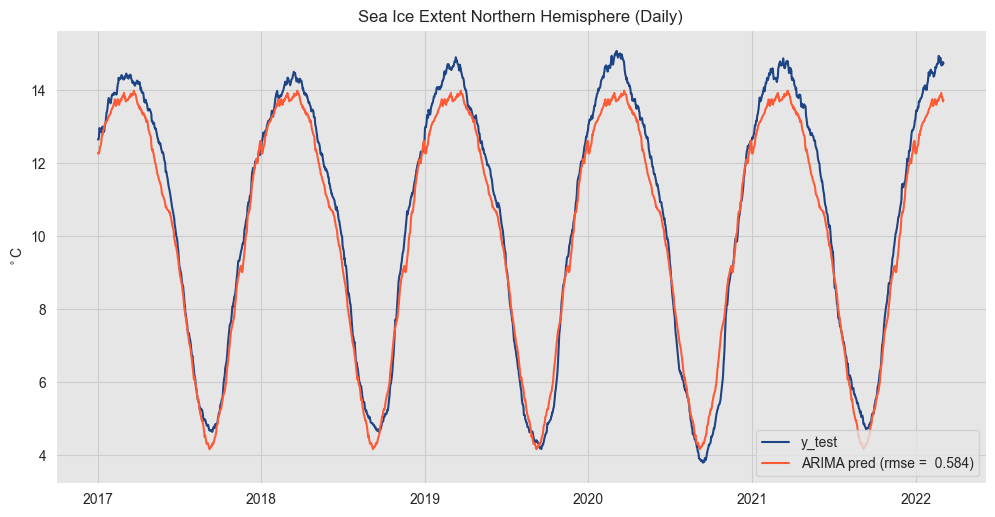

In [69]:
from sklearn.metrics import mean_squared_error

#mse_arima = mean_squared_error(y_true=y_test, y_pred=y_pred_arima)
rmse_arima = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_arima))

fig, ax = plt.subplots()
sns.lineplot(x=t_test, y=y_test, color=sns_c[2], label='y_test', ax=ax)
#sns.lineplot(x=t_test, y=y_pred_arima, color=sns_c[3], label=f'ARIMA pred (mse = {mse_arima: 0.3f})', ax=ax)
sns.lineplot(x=t_test, y=y_pred_arima, color=sns_c[1], label=f'ARIMA pred (rmse = {rmse_arima: 0.3f})', ax=ax)
#sns.lineplot(x=t_test, y=y_pred_es, color=sns_c[4], label=f'ES pred (mse = {mse_es: 0.3f})', ax=ax)
ax.set(title='Sea Ice Extent Northern Hemisphere (Daily)', ylabel=r'$^\circ$C');

In [4]:
# y_pred_arima.plot_diagnostics(figsize=(10,8))
# plt.show()

### Summary

Here we can see that the forecasting is not good using ARIMA, since the time series exhibits seasonality.
So, now we will implement Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (SARIMAX)